# Most Valuable Customers
 
 ## Background
 The (hypothetical) company in which I work as a senior data analyst, Summit Outfitters, has recently secured a substantial round of investment to expand its market presence both online and in flagship stores located in prime outdoor destinations. Summit Outfitters is known for its premium gear catering to outdoor enthusiasts, including climbers, hikers, skiers, and trail runners. 
 
 The company has maintained steady growth through a loyal customer base and strong brand reputation. Now, under the strategic guidance of our visionary CEO, Alex Rivera, Summit Outfitters is ready to leverage its current momentum and tap into broader markets. Alex believes that a deep understanding of the company's current customer base will allow us to refine our marketing efforts, enhance product offerings, and increase sales efficiency, leading us to new heights of success. 

 Alex Rivera approached me with a strategic request from the recent investment round. The investors are interested in maximizing returns by enhancing the efficiency of marketing spend and increasing the average customer lifetime value. They want to focus on two key areas:
 - Identifying the most valuable customers from the existing customer base. What makes these customers valuable? The goal is to understand what makes these customers valuable, whether it's through their purchasing patterns, loyalty, or average transaction value. This understanding will help in tailoring marketing campaigns and loyalty programs that effectively target and retain these segments.
 - Exploring cross-selling and up-selling opportunities. With a diverse range of products, from technical climbing gear to premium outdoor apparel, Alex believes there is untapped potential in cross-selling and upselling. He wants you to use the customer transaction data to identify opportunities where customers purchasing certain items might be interested in others. For example, customers buying high-end skis might be potential targets for premium ski wear or exclusive ski accessories.

Alex expects a comprehensive report that not only identifies key customer segments and outlines potential cross-sell and upsell strategies but also provides actionable insights and practical recommendations for targeted marketing initiatives. The focus is on enhancing customer experience and maximizing revenue per customer, and my expertise will play a significant part in achieving these goals.

## Approach
To address Alex Rivera's strategic request, I will follow a structured approach that involves the following key steps:
1. Understand the problem, including the definitions of individual words/concepts.
2. Determine a minimum viable answer that we can use to make a decision and prompt further questions.
3. Identify any additional information that would be helpful (data, people, etc.) to have to get the minimum viable answer.
4. Obtain the data. 
5. Plan and execute the work required to get the minimum viable answer.
6. Review the results and determine if we need to do more work.
7. Iterate as needed.

### Understand
- **Most Valuable Customers**: These are customers who contribute significantly to the company's revenue and profitability. They may exhibit high purchase frequency, high average transaction value, or long-term loyalty.
- **Cross-Selling**: This involves selling additional products or services to an existing customer. The goal is to increase the customer's value by offering complementary or related items.
- **Up-Selling**: This involves persuading a customer to buy a more expensive version of a product or to add features or upgrades. The goal is to increase the customer's spending per transaction.

### Minimum Viable Answers
1. Who are our most valuable customers?
2. In which customer segments can we leverage cross-selling and up-selling opportunities?

### Data
*This data comes from the publicly-avaiable [Online Retail Customer Churn Dataset](https://www.kaggle.com/datasets/hassaneskikri/online-retail-customer-churn-dataset) on Kaggle. For the sake of this case study, let's pretend that it came from our company's data lake.*

I ran the following query on our company's data lake to pull the relevant data:
```sql
with customer_bio as (
        select Customer_ID
        , Age
        , Gender
        , Annual_Income 
        from customers c)
    , customer_activity as (
        select sum(Purchase_Amt) over (partition by Customer_ID) as Total_Spend
        , date_diff(max(date(Timestamp)), min(date(Timestamp)), year) as Years_as_Customer
        , count(*) over (partition by Customer_ID) as Num_of_Purchases
        , avg(purchase_amt) over (partition by Customer_ID) as Average_Transaction_Amount
        , sum(Return_Amt) over (partition by Customer_ID) as Num_of_Returns
        , date_diff(current_date(), max(date(Timestamp)) over (partition by Customer_ID), day) as Last_Purchase_Days_Ago 
        from purchases p)
select cb.Customer_ID
    , cb.Age
    , cb.Gender
    , cb.Annual_Income
    , ca.Total_Spend
    , ca.Years_as_Customer
    , ca.Num_of_Purchases
    , ca.Average_Transaction_Amount
    , ca.Num_of_Returns
    , ca.Last_Purchase_Days_Ago
from customer_bio cb join customer_activity ca on cb.Customer_ID = ca.Customer_ID
limit 1000;
```
to get the following columns: 
- Customer_ID
- Age
- Gender
- Annual_Income
- Total_Spend
- Years_as_Customer
- Num_of_Purchases
- Average_Transaction_Amount
- Num_of_Returns
- Last_Purchase_Days_Ago

### Do the Work

In [59]:
import pandas as pd
df = pd.read_csv("../data/online_retail_customer_churn.csv", 
                 usecols=["Customer_ID", "Age", "Gender", "Annual_Income", "Total_Spend", "Years_as_Customer", 
                          "Num_of_Purchases", "Average_Transaction_Amount", "Num_of_Returns", "Last_Purchase_Days_Ago"],
                 index_col="Customer_ID")

In [60]:
df.head()

,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Last_Purchase_Days_Ago
Customer_ID,,,,,,,,,
1,62,Other,45.15,5892.58,5,22,453.80,2,129
2,65,Male,79.51,9025.47,13,77,22.90,2,227
3,18,Male,29.19,618.83,13,71,50.53,5,283
4,21,Other,79.63,9110.30,3,33,411.83,5,226
5,21,Other,77.66,5390.88,15,43,101.19,3,242


In [61]:
# Let's check whether there are any missing values in the dataset
df.isnull().sum()

Age                           0
Gender                        0
Annual_Income                 0
Total_Spend                   0
Years_as_Customer             0
Num_of_Purchases              0
Average_Transaction_Amount    0
Num_of_Returns                0
Last_Purchase_Days_Ago        0
dtype: int64

In [62]:
# Let me step out of this case study for a moment. I have rarely seen a dataset with no missing values. Let's make this more realistic.
import numpy as np

# Determine the number of values to replace with missing values: 1.5% of the dataset
n_missing = int(df.size * 0.025)

# Create a Boolean mask of the same shape as the dataframe, with n_missing elements set to True
mask = np.random.choice([True, False], size=df.shape, p=[0.015, 0.985])

# Apply the mask to the dataframe
df = df.mask(mask)

#### Cleaning and Exploring the Data
Let's start by exploring the data's structure and contents. Let's check for missing values, outliers and any other data quality issues that need to be addressed.

In [63]:
# Check import dtypes and convert them to the best possible dtypes. This is a small dataset, but it's a good practice to do this anyway.
print(f"Old dtypes:\n{df.dtypes}")
df = df.convert_dtypes()
print(f"New dtypes:\n{df.dtypes}")

Old dtypes:
Age                           float64
Gender                         object
Annual_Income                 float64
Total_Spend                   float64
Years_as_Customer             float64
Num_of_Purchases              float64
Average_Transaction_Amount    float64
Num_of_Returns                float64
Last_Purchase_Days_Ago        float64
dtype: object
New dtypes:
Age                                    Int64
Gender                        string[python]
Annual_Income                        Float64
Total_Spend                          Float64
Years_as_Customer                      Int64
Num_of_Purchases                       Int64
Average_Transaction_Amount           Float64
Num_of_Returns                         Int64
Last_Purchase_Days_Ago                 Int64
dtype: object


In [64]:
df.info()
print(f"\nThe DataFrame is {df.shape[0]} samples long.")

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         989 non-null    Int64  
 1   Gender                      989 non-null    string 
 2   Annual_Income               987 non-null    Float64
 3   Total_Spend                 985 non-null    Float64
 4   Years_as_Customer           986 non-null    Int64  
 5   Num_of_Purchases            987 non-null    Int64  
 6   Average_Transaction_Amount  983 non-null    Float64
 7   Num_of_Returns              981 non-null    Int64  
 8   Last_Purchase_Days_Ago      986 non-null    Int64  
dtypes: Float64(3), Int64(5), string(1)
memory usage: 85.9 KB

The DataFrame is 1000 samples long.


In [65]:
df.describe(include="all")

,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Last_Purchase_Days_Ago
count,989.0,989,987.0,985.0,986.0,987.0,983.0,981.0,986.0
unique,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,<NA>,Female,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,<NA>,338,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,43.296259,NaN,112.32694,5087.138569,9.726166,49.509625,265.90588,4.625892,183.400609
std,15.277202,NaN,52.812302,2862.184367,5.530172,28.529737,145.580991,2.897167,104.276433
min,18.0,NaN,20.01,117.2,1.0,1.0,10.46,0.0,1.0
25%,30.0,NaN,68.15,2679.42,5.0,25.0,139.01,2.0,93.0
50%,43.0,NaN,115.05,5000.22,9.0,49.0,267.84,5.0,181.5
75%,56.0,NaN,158.57,7607.82,14.0,74.0,400.605,7.0,274.0


In [66]:
# What immediately pops out are the three unique genders. Let's see how those are categorized.
df["Gender"].value_counts()

Gender
Female    338
Male      327
Other     324
Name: count, dtype: Int64

The `Gender`s look valid and evenly-distributed, so we don't need to do sophisticated imputation on that variable.

Looking at the numeric columns, the mean and standard deviation of each column looks very close to the corresponding median and 75th percentile. This gestures towards normality, but the min and max values around around two standard deviations from the mean, so visualizing the distributions will be helpful.

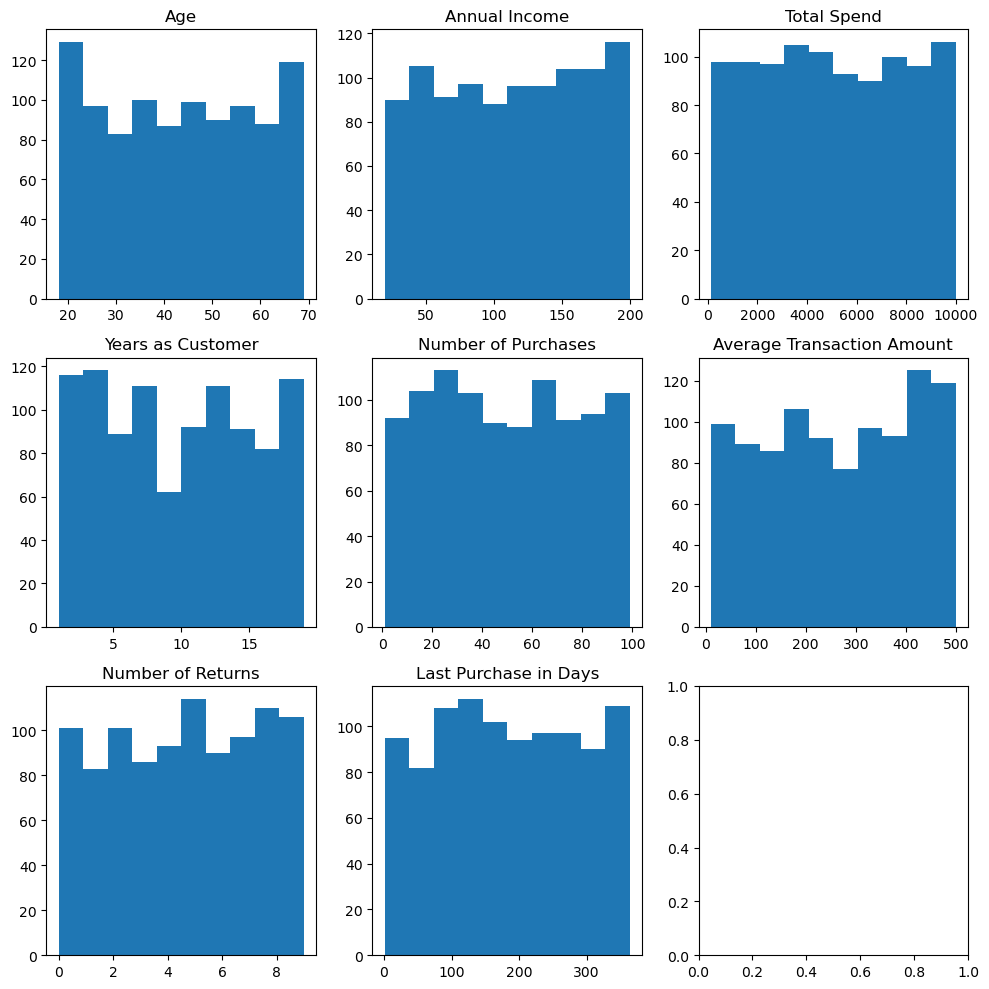

In [67]:

# Let's plot histograms of the numeric columns.
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes[0, 0].hist(df["Age"])
axes[0, 0].set_title("Age")

axes[0, 1].hist(df["Annual_Income"])
axes[0, 1].set_title("Annual Income")

axes[0, 2].hist(df["Total_Spend"])
axes[0, 2].set_title("Total Spend")

axes[1, 0].hist(df["Years_as_Customer"])
axes[1, 0].set_title("Years as Customer")

axes[1, 1].hist(df["Num_of_Purchases"])
axes[1, 1].set_title("Number of Purchases")

axes[1, 2].hist(df["Average_Transaction_Amount"])
axes[1, 2].set_title("Average Transaction Amount")

axes[2, 0].hist(df["Num_of_Returns"])
axes[2, 0].set_title("Number of Returns")

axes[2, 1].hist(df["Last_Purchase_Days_Ago"])
axes[2, 1].set_title("Last Purchase in Days")

plt.tight_layout()
plt.show()

They're all skewed, so we will need to think about our imputation method. We have several options:
- Mean: This is probably not the best choice, as the distributions are skewed. It's trivial to impute and compare the results to the original dataset's summary statistics, but I'm not sure it will be the most accurate.
- Median: This is a better choice for skewed distributions, but it's not perfect. It's also trivial to impute and compare the results to the original dataset's summary statistics.
- Mode: If the datasets exhibited any peakedness, this may be a good choice. In this case, however, it's not appropriate.
- K-means/Multivariate: This is the most sophisticated method, but it's also the most accurate. It's not trivial to implement, but it can be worth the effort.

My instinct is to use the median, as it's the most appropriate for skewed distributions and it's trivial to implement. I'll compare the results of mean and median imputation to the original dataset's summary statistics to see which is the better choice. K-means imputation is attractive, but there are three reasons I'm not going to use it unless absolutely necessary:
1. The number of missing points is extremely low, so inaccurate values should not significantly affect the overall distribution. 
2. This analysis is coming on the heels of a recent investing round. It would be better to get a quick answer and iterate than to spend a lot of time on a sophisticated method that may not be necessary. I would rather spend more time analyzing the results and iterating on the analysis than overinvesting in the imputation method.
3. We will be looking at clusters, so our precision in imputation is less important than it would be in a regression or classification problem.

First, let's fill the `Gender` column, then we'll impute the missing values in the numeric columns.

In [68]:
num_missing = df["Gender"].isnull().sum()
imputed_genders = np.random.choice(["Female", "Male", "Other"], size=num_missing, p=[0.33, 0.33, 0.34])
df.loc[df['Gender'].isnull(), 'Gender'] = imputed_genders

print(df["Gender"].value_counts())
print(f"\n{df["Gender"].isnull().sum()} missing values remain.")

Gender
Female    342
Male      331
Other     327
Name: count, dtype: Int64

0 missing values remain.


In [69]:
# Let's return to the numeric columns and compare mean vs. median imputation.
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

def mean_imputation(df, column_list=None):
    if column_list is None:
        column_list = df.select_dtypes(include=[np.number]).columns.tolist()
    for column in column_list:
        if df[column].dtype == np.float64:
            mean_value = df[column].fillna(df[column].mean())
        elif df[column].dtype in [np.int64, np.int32]:
            mean_value = int(df[column].fillna(df[column].mean()))
        df[column] = df.fillna[mean_value]
    return df

def median_imputation(df, column_list=None):
    if column_list is None:
        column_list = df.select_dtypes(include=[np.number]).columns.tolist()
    for column in column_list:
        if df[column].dtype == np.float64:
            median_value = df[column].fillna(df[column].median())
        elif df[column].dtype in [np.int64, np.int32]:
            median_value = int(df[column].fillna(df[column].median()))
        df[column] = df.fillna[median_value]
    return df

df_mean = mean_imputation(df.copy(), numeric_columns)
df_median = median_imputation(df.copy(), numeric_columns)

UnboundLocalError: cannot access local variable 'mean_value' where it is not associated with a value